# Amazon Stock Price Direction Prediction

**DISCLAIMER**: This work is for educational purposes only and does not constitute financial advice. The objective of this project is to explore the application of machine learning models in predicting Amazon stock market behavior and to evaluate their limitations.

**What we're doing:** Predicting if tomorrow's Amazon stock will go UP or DOWN

**Why?** If we know the direction, we can:
- Buy at opening if we predict UP
- Don't buy (or sell) if we predict DOWN




**The task:** Binary classification
- Target = 1 means tomorrow closes HIGHER than it opens (UP day)
- Target = 0 means tomorrow closes LOWER than it opens (DOWN day)

**Success criteria:** Get AUC score > 0.515 (better than random guessing)

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


We have Amazon stock data from 1997 to 2020 split into three files:
- **Training data** (1997-2016): We use this to teach our model
- **Validation data** (2016-2018): We use this to pick the best model
- **Test data** (2018-2020): We use this for final evaluation (the model has never seen this!)

Each file has the same columns:
- Date
- Open (opening price)
- High (highest price that day)
- Low (lowest price that day)
- Close (closing price)
- Adj Close (adjusted closing price)
- Volume (number of shares traded)

In [5]:
# Load the three CSV files
train_df = pd.read_csv('datasets/AMZN_train.csv', parse_dates=['Date'])
val_df = pd.read_csv('datasets/AMZN_val.csv', parse_dates=['Date'])
test_df = pd.read_csv('datasets/AMZN_test.csv', parse_dates=['Date'])

# Check the sizes
print("Dataset Sizes:")
print(f"  Training:   {len(train_df):,} days")
print(f"  Validation: {len(val_df):,} days")
print(f"  Test:       {len(test_df):,} days")

# Look at the first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Dataset Sizes:
  Training:   4,781 days
  Validation: 503 days
  Test:       504 days

First 5 rows of training data:


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


Next, we need to create what we're trying to predict. 

**Our target:** Will tomorrow be an UP day or DOWN day?
- UP day (1): Tomorrow's close > tomorrow's open
- DOWN day (0): Tomorrow's close < tomorrow's open

**How we do it:**
1. Shift the data to get "next day" values
2. Compare next day's close to next day's open
3. Create binary target (1 or 0)

In [6]:
# Create target variable
def create_target(df):
    """
    Create the target variable for prediction.
    Returns a dataframe with a new 'target' column.
    """
    # Make a copy so we don't modify the original
    df = df.copy()
    
    # Get tomorrow's open and close by shifting up by 1 row
    # shift(-1) means "give me the next row's value"
    df['next_open'] = df['Open'].shift(-1)
    df['next_close'] = df['Close'].shift(-1)
    
    # Create target: 1 if next close > next open, else 0
    df['target'] = (df['next_close'] > df['next_open']).astype(int)
    
    # Remove the last row (it has no "next day" data)
    df = df[:-1].reset_index(drop=True)
    
    return df

# Apply to all three datasets
train_df = create_target(train_df)
val_df = create_target(val_df)
test_df = create_target(test_df)

# Check target distribution
print("Target distribution in training data:")
print(train_df['target'].value_counts())
print(f"\nPercentage of UP days: {train_df['target'].mean()*100:.1f}%")
print(f"Percentage of DOWN days: {(1-train_df['target'].mean())*100:.1f}%")

Target distribution in training data:
target
1    2392
0    2388
Name: count, dtype: int64

Percentage of UP days: 50.0%
Percentage of DOWN days: 50.0%


### Feature Engineering

This is the most important part! We'll create "features" (clues) that help predict the target.

Think of features as pieces of information the model uses to make decisions.

**We'll create 10 groups of features:**

1. **Basic Price Features** - Today's price movements
2. **Gap Features** - Overnight price changes (very important!)
3. **Moving Averages** - Trend indicators
4. **Volatility Features** - How jumpy is the stock?
5. **Momentum Features** - Is it speeding up or slowing down?
6. **Volume Features** - Trading activity
7. **Pattern Features** - Consecutive up/down days
8. **Technical Indicators** - RSI and MACD (professional tools)
9. **Lag Features** - Yesterday's patterns
10. **Time Features** - Day of week, month, etc.

In [7]:
## Feature Engineering

def create_features(df):
    """
    Create all features from the raw stock data.
    This is where the magic happens!
    """
    df = df.copy()
    
    # ==========================================
    # GROUP 1: BASIC PRICE FEATURES
    # ==========================================
    
    # Daily return: did we go up or down today?
    df['daily_return'] = (df['Close'] - df['Open']) / df['Open']
    
    # Intraday range: how much did price move today?
    df['intraday_range'] = (df['High'] - df['Low']) / df['Open']
    
    # Close position: where did we close in today's range?
    # Value near 1 = closed near the high (bullish)
    # Value near 0 = closed near the low (bearish)
    df['close_position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    
    # ==========================================
    # GROUP 2: GAP FEATURES
    # ==========================================
    
    # Gap: how much did we gap up or down at open?
    # Positive gap = opened higher than yesterday's close (good news overnight)
    # Negative gap = opened lower (bad news overnight)
    df['gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
    df['gap_size'] = df['gap'].abs()
    
    # ==========================================
    # GROUP 3: MOVING AVERAGES (Trends)
    # ==========================================
    
    # Calculate moving averages for different windows
    for window in [5, 10, 20]:
        # Moving average
        df[f'ma_{window}'] = df['Close'].rolling(window).mean()
        
        # How far is current price from this moving average?
        df[f'price_to_ma_{window}'] = (df['Close'] - df[f'ma_{window}']) / df[f'ma_{window}']
    
    # Trend strength: is short-term MA above long-term MA?
    df['ma_trend_5_20'] = (df['ma_5'] - df['ma_20']) / df['ma_20']
    
    # ==========================================
    # GROUP 4: VOLATILITY FEATURES
    # ==========================================
    
    # Standard deviation of returns (how much prices jump around)
    for window in [5, 10, 20]:
        df[f'volatility_{window}'] = df['daily_return'].rolling(window).std()
    
    # Bollinger position: how far from MA in terms of standard deviations?
    df['bollinger_position'] = (df['Close'] - df['ma_20']) / (df['volatility_20'] * 2 + 1e-10)
    
    # ==========================================
    # GROUP 5: MOMENTUM FEATURES
    # ==========================================
    
    # Price change over different time periods
    for window in [3, 5, 10, 20]:
        df[f'momentum_{window}'] = df['Close'].pct_change(window)
    
    # Is momentum accelerating or decelerating?
    df['momentum_acceleration'] = df['momentum_5'] - df['momentum_10']
    
    # ==========================================
    # GROUP 6: VOLUME FEATURES
    # ==========================================
    
    # Volume moving averages
    df['volume_ma_5'] = df['Volume'].rolling(5).mean()
    df['volume_ma_20'] = df['Volume'].rolling(20).mean()
    
    # Volume ratio: is today's volume higher than usual?
    df['volume_ratio_5'] = df['Volume'] / (df['volume_ma_5'] + 1)
    df['volume_ratio_20'] = df['Volume'] / (df['volume_ma_20'] + 1)
    
    # Price-volume relationship
    df['price_volume'] = df['daily_return'] * np.log(df['Volume'] + 1)
    
    # ==========================================
    # GROUP 7: PATTERN FEATURES
    # ==========================================
    
    # How many of the last 5 days were up/down?
    df['consecutive_up'] = (df['daily_return'] > 0).rolling(5).sum()
    df['consecutive_down'] = (df['daily_return'] < 0).rolling(5).sum()
    
    # How far are we from recent high/low?
    df['distance_from_high_20'] = (df['High'].rolling(20).max() - df['Close']) / df['Close']
    df['distance_from_low_20'] = (df['Close'] - df['Low'].rolling(20).min()) / df['Close']
    
    # ==========================================
    # GROUP 8: TECHNICAL INDICATORS
    # ==========================================
    
    # RSI (Relative Strength Index)
    # Measures if stock is overbought (>70) or oversold (<30)
    gain = df['Close'].diff().clip(lower=0)
    loss = -df['Close'].diff().clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    # Trend-following momentum indicator
    ema_12 = df['Close'].ewm(span=12).mean()
    ema_26 = df['Close'].ewm(span=26).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    
    # ==========================================
    # GROUP 9: LAG FEATURES
    # ==========================================
    
    # Yesterday's and day-before-yesterday's values
    for lag in [1, 2, 3]:
        df[f'return_lag_{lag}'] = df['daily_return'].shift(lag)
        df[f'volume_ratio_lag_{lag}'] = df['volume_ratio_5'].shift(lag)
    
    # ==========================================
    # GROUP 10: TIME FEATURES
    # ==========================================
    
    # Day of week (Monday=0, Friday=4)
    df['day_of_week'] = df['Date'].dt.dayofweek
    
    # Month (seasonality)
    df['month'] = df['Date'].dt.month
    
    # Beginning or end of month?
    df['day_of_month'] = df['Date'].dt.day
    df['is_month_start'] = (df['day_of_month'] <= 7).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 23).astype(int)
    
    return df

print("Feature engineering function created!")

Feature engineering function created!


In [8]:
# Apply the features into the datasets
print("Creating features for training data...")
train_df = create_features(train_df)

print("Creating features for validation data...")
val_df = create_features(val_df)

print("Creating features for test data...")
test_df = create_features(test_df)

print("\n✓ Feature engineering complete!")
print(f"Total columns now: {len(train_df.columns)}")

Creating features for training data...
Creating features for validation data...
Creating features for test data...

✓ Feature engineering complete!
Total columns now: 55


In [10]:
# List of all feature columns we created

feature_columns = [
    # Basic
    'daily_return', 'intraday_range', 'close_position',
    # Gap
    'gap', 'gap_size',
    # Moving Averages
    'price_to_ma_5', 'price_to_ma_10', 'price_to_ma_20', 'ma_trend_5_20',
    # Volatility
    'volatility_5', 'volatility_10', 'volatility_20', 'bollinger_position',
    # Momentum
    'momentum_3', 'momentum_5', 'momentum_10', 'momentum_20', 'momentum_acceleration',
    # Volume
    'volume_ratio_5', 'volume_ratio_20', 'price_volume',
    # Patterns
    'consecutive_up', 'consecutive_down', 'distance_from_high_20', 'distance_from_low_20',
    # Technical
    'rsi_14', 'macd', 'macd_signal', 'macd_diff',
    # Lags
    'return_lag_1', 'return_lag_2', 'return_lag_3',
    'volume_ratio_lag_1', 'volume_ratio_lag_2', 'volume_ratio_lag_3',
    # Time
    'day_of_week', 'month', 'is_month_start', 'is_month_end'
]

print(f"Total features: {len(feature_columns)}")
print("\nFeature list:")
for i, feat in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feat}")

Total features: 39

Feature list:
 1. daily_return
 2. intraday_range
 3. close_position
 4. gap
 5. gap_size
 6. price_to_ma_5
 7. price_to_ma_10
 8. price_to_ma_20
 9. ma_trend_5_20
10. volatility_5
11. volatility_10
12. volatility_20
13. bollinger_position
14. momentum_3
15. momentum_5
16. momentum_10
17. momentum_20
18. momentum_acceleration
19. volume_ratio_5
20. volume_ratio_20
21. price_volume
22. consecutive_up
23. consecutive_down
24. distance_from_high_20
25. distance_from_low_20
26. rsi_14
27. macd
28. macd_signal
29. macd_diff
30. return_lag_1
31. return_lag_2
32. return_lag_3
33. volume_ratio_lag_1
34. volume_ratio_lag_2
35. volume_ratio_lag_3
36. day_of_week
37. month
38. is_month_start
39. is_month_end


## Prepare Data for Modeling

Now we need to:
1. Remove rows with missing values (NaN) - these come from rolling calculations
2. Separate features (X) from target (y)
3. Scale the features so they're on the same scale

**Why scale?** Some features might be 0.001 (returns) while others are 1,000,000 (volume). 
We need them comparable so the model treats them fairly.

In [11]:
# Remove rows with NaN values
train_clean = train_df.dropna().reset_index(drop=True)
val_clean = val_df.dropna().reset_index(drop=True)
test_clean = test_df.dropna().reset_index(drop=True)

# Separate features (X) and target (y)
X_train = train_clean[feature_columns]
y_train = train_clean['target']

X_val = val_clean[feature_columns]
y_val = val_clean['target']

X_test = test_clean[feature_columns]
y_test = test_clean['target']

print("Data after cleaning:")
print(f"  Training:   {len(X_train):,} samples")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test:       {len(X_test):,} samples")

# Scale features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data prepared and scaled!")

Data after cleaning:
  Training:   4,760 samples
  Validation: 482 samples
  Test:       483 samples

✓ Data prepared and scaled!


## Train Multiple Models

We'll try three different machine learning algorithms and see which works best:

1. **Logistic Regression** - Simple linear model, fast but limited
2. **Random Forest** - Builds 200 decision trees and votes
3. **Gradient Boosting** - Builds trees sequentially, each fixing previous errors

We'll train all three and compare them on the validation set.

In [12]:
# Dictionary to store our models
models = {}

# Model 1: Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42, C=0.1)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr
print("  ✓ Done")

# Model 2: Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,      # 200 trees
    max_depth=15,          # max tree depth
    min_samples_split=20,  # min samples to split a node
    min_samples_leaf=10,   # min samples in a leaf
    random_state=42,
    n_jobs=-1              # use all CPU cores
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
print("  ✓ Done")

# Model 3: Gradient Boosting
print("\nTraining Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=200,      # 200 trees
    max_depth=5,           # shallower trees
    learning_rate=0.05,    # how much each tree contributes
    subsample=0.8,         # use 80% of data for each tree
    random_state=42
)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
print("  ✓ Done")

print("\n" + "="*50)
print("All models trained successfully!")
print("="*50)

Training Logistic Regression...
  ✓ Done

Training Random Forest...
  ✓ Done

Training Gradient Boosting...
  ✓ Done

All models trained successfully!


## Evaluate on Validation Set

Now we test each model on the validation data (2016-2018) to see which performs best.

**Metrics we'll use:**
- **AUC (Area Under Curve)**: Measures how well the model separates UP from DOWN days
  - 0.5 = random guessing
  - 1.0 = perfect predictions
  - **Our goal: > 0.515**
- **Accuracy**: What percentage did we predict correctly?

In [13]:
# Store results
results = {}

print("Evaluating models on validation set:")
print("="*60)

for name, model in models.items():
    # Get predictions
    if name == 'Logistic Regression':
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = model.predict(X_val_scaled)
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_val, y_pred_proba)
    acc_score = accuracy_score(y_val, y_pred)
    
    # Store results
    results[name] = {
        'auc': auc_score,
        'accuracy': acc_score,
        'model': model
    }
    
    # Print results
    print(f"\n{name}:")
    print(f"  AUC:      {auc_score:.4f} {'✓ PASS' if auc_score > 0.515 else '✗ FAIL'}")
    print(f"  Accuracy: {acc_score:.4f} ({acc_score*100:.2f}%)")

# Find the best model
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
best_model = results[best_model_name]['model']
best_auc = results[best_model_name]['auc']

print("\n" + "="*60)
print(f"BEST MODEL: {best_model_name}")
print(f"Validation AUC: {best_auc:.4f}")
print("="*60)

Evaluating models on validation set:

Logistic Regression:
  AUC:      0.4794 ✗ FAIL
  Accuracy: 0.4647 (46.47%)

Random Forest:
  AUC:      0.5073 ✗ FAIL
  Accuracy: 0.4834 (48.34%)

Gradient Boosting:
  AUC:      0.5229 ✓ PASS
  Accuracy: 0.5311 (53.11%)

BEST MODEL: Gradient Boosting
Validation AUC: 0.5229


## Final Evaluation on Test Set

Now for the moment of truth! We'll test our best model on data it has NEVER seen before (2018-2020).

This is the real test of how well our model generalizes to new, unseen data.

In [14]:
print("="*60)
print("FINAL EVALUATION ON TEST SET (2018-2020)")
print("="*60)

# Make predictions on test set
if best_model_name == 'Logistic Regression':
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    y_test_pred = best_model.predict(X_test_scaled)
else:
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)

# Calculate final metrics
final_auc = roc_auc_score(y_test, y_test_pred_proba)
final_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"\nModel: {best_model_name}")
print(f"\nTest AUC:      {final_auc:.4f} {'✓ SUCCESS!' if final_auc > 0.515 else '✗ Below target'}")
print(f"Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

# Detailed classification report
print("\n" + "-"*60)
print("Detailed Performance by Class:")
print("-"*60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['DOWN (0)', 'UP (1)'],
                          digits=4))

FINAL EVALUATION ON TEST SET (2018-2020)

Model: Gradient Boosting

Test AUC:      0.5378 ✓ SUCCESS!
Test Accuracy: 0.5155 (51.55%)

------------------------------------------------------------
Detailed Performance by Class:
------------------------------------------------------------
              precision    recall  f1-score   support

    DOWN (0)     0.5166    0.6393    0.5714       244
      UP (1)     0.5138    0.3891    0.4429       239

    accuracy                         0.5155       483
   macro avg     0.5152    0.5142    0.5071       483
weighted avg     0.5152    0.5155    0.5078       483



## Analyze Feature Importance

Let's see which features were most important for making predictions.

This tells us what the model found most useful when deciding if tomorrow will be UP or DOWN.

In [15]:
# Only works for tree-based models (Random Forest, Gradient Boosting)
if hasattr(best_model, 'feature_importances_'):
    # Create dataframe of feature importances
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("="*60)
    print("TOP 15 MOST IMPORTANT FEATURES")
    print("="*60)
    print(f"\n{'Feature':<30} {'Importance':>12} {'Percentage':>12}")
    print("-"*60)
    
    total_importance = importance_df['importance'].sum()
    for idx, row in importance_df.head(15).iterrows():
        pct = (row['importance'] / total_importance) * 100
        print(f"{row['feature']:<30} {row['importance']:>12.4f} {pct:>11.2f}%")
    
    # Store for plotting later
    top_features = importance_df.head(15)
    
else:
    # For logistic regression, use coefficients
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': np.abs(best_model.coef_[0])
    }).sort_values('coefficient', ascending=False)
    
    print("="*60)
    print("TOP 15 FEATURES BY ABSOLUTE COEFFICIENT")
    print("="*60)
    print(f"\n{'Feature':<30} {'|Coefficient|':>15}")
    print("-"*60)
    
    for idx, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:<30} {row['coefficient']:>15.4f}")

TOP 15 MOST IMPORTANT FEATURES

Feature                          Importance   Percentage
------------------------------------------------------------
volume_ratio_20                      0.0421        4.21%
gap                                  0.0421        4.21%
volume_ratio_lag_3                   0.0409        4.09%
volume_ratio_lag_2                   0.0407        4.07%
close_position                       0.0370        3.70%
volume_ratio_lag_1                   0.0365        3.65%
gap_size                             0.0354        3.54%
return_lag_1                         0.0347        3.47%
distance_from_low_20                 0.0342        3.42%
momentum_5                           0.0341        3.41%
return_lag_2                         0.0340        3.40%
macd_diff                            0.0326        3.26%
return_lag_3                         0.0326        3.26%
momentum_acceleration                0.0316        3.16%
volatility_10                        0.0313        3

## Visualizations

Let's create some plots to better understand our results.

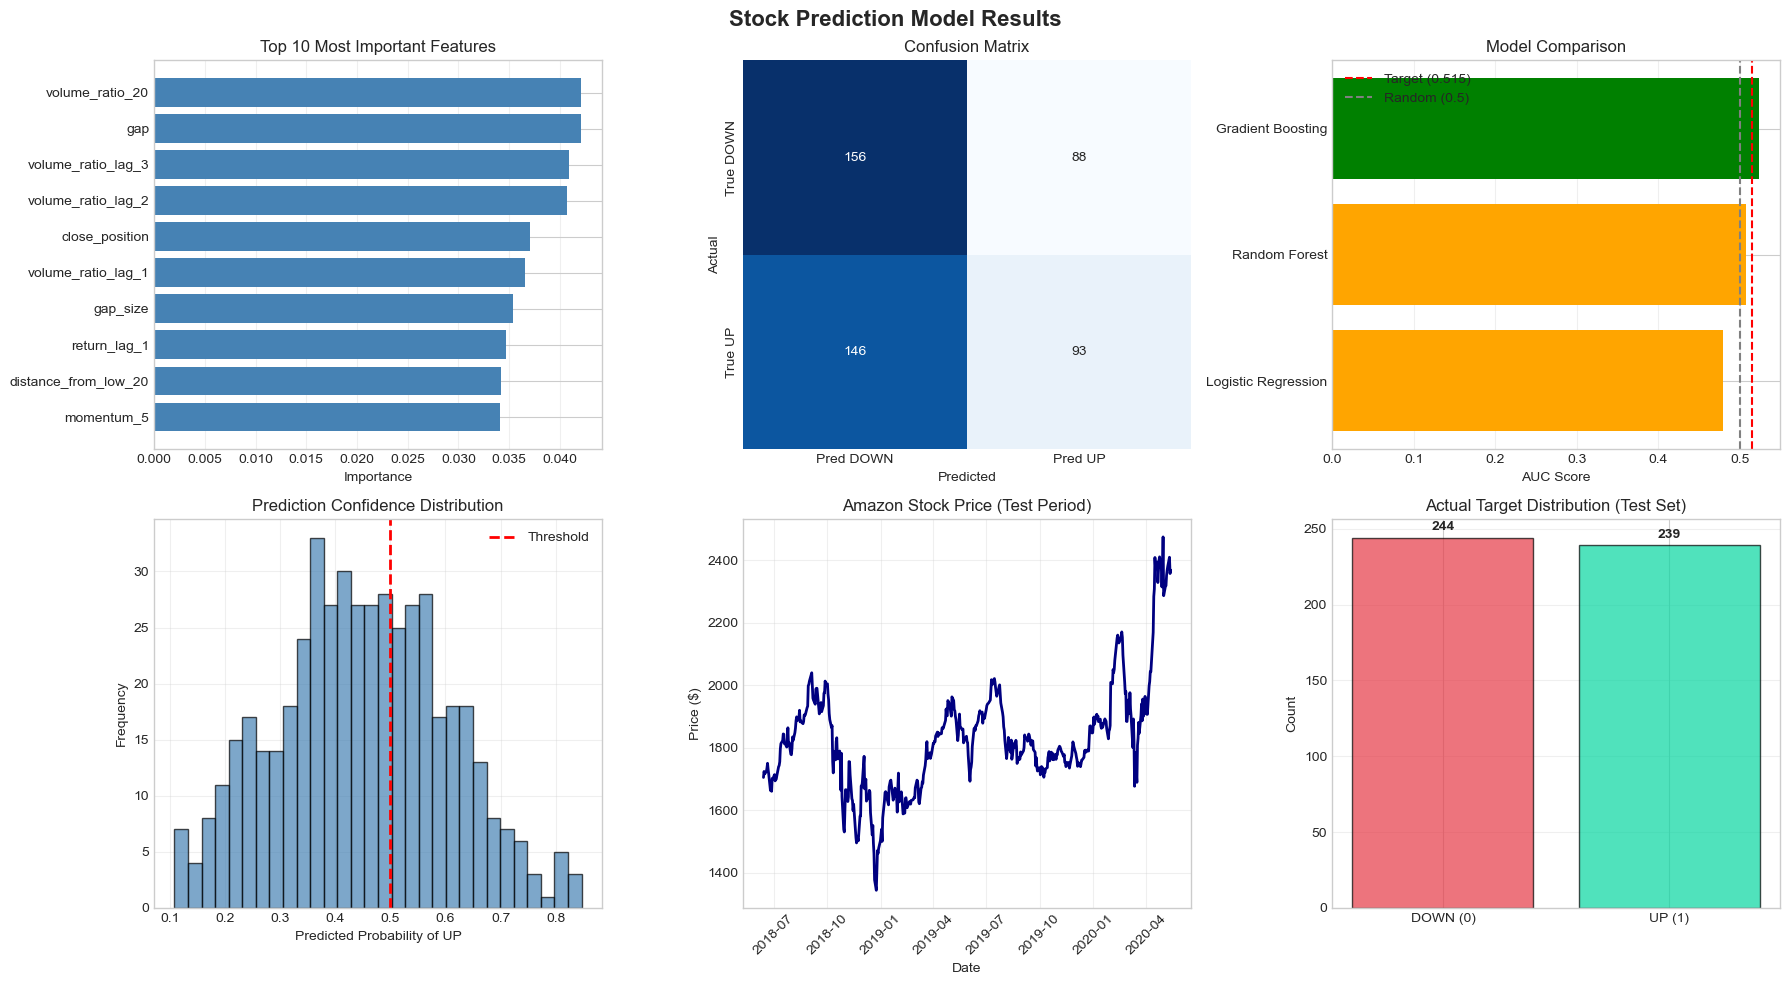

In [16]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Stock Prediction Model Results', fontsize=16, fontweight='bold')

# 1. Feature Importance (if available)
ax1 = axes[0, 0]
if hasattr(best_model, 'feature_importances_'):
    top_10 = importance_df.head(10).sort_values('importance')
    ax1.barh(top_10['feature'], top_10['importance'], color='steelblue')
    ax1.set_xlabel('Importance')
    ax1.set_title('Top 10 Most Important Features')
    ax1.grid(axis='x', alpha=0.3)

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False,
            xticklabels=['Pred DOWN', 'Pred UP'],
            yticklabels=['True DOWN', 'True UP'])
ax2.set_title('Confusion Matrix')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. Model Comparison
ax3 = axes[0, 2]
model_names = list(results.keys())
auc_scores = [results[m]['auc'] for m in model_names]
colors = ['green' if auc > 0.515 else 'orange' for auc in auc_scores]
ax3.barh(model_names, auc_scores, color=colors)
ax3.axvline(x=0.515, color='red', linestyle='--', label='Target (0.515)')
ax3.axvline(x=0.5, color='gray', linestyle='--', label='Random (0.5)')
ax3.set_xlabel('AUC Score')
ax3.set_title('Model Comparison')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Prediction Confidence
ax4 = axes[1, 0]
ax4.hist(y_test_pred_proba, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
ax4.set_xlabel('Predicted Probability of UP')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Confidence Distribution')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Stock Price Over Time
ax5 = axes[1, 1]
ax5.plot(test_clean['Date'], test_clean['Close'], linewidth=2, color='navy')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price ($)')
ax5.set_title('Amazon Stock Price (Test Period)')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(alpha=0.3)

# 6. Target Distribution
ax6 = axes[1, 2]
target_counts = test_clean['target'].value_counts()
ax6.bar(['DOWN (0)', 'UP (1)'], target_counts.values, 
        color=['#E63946', '#06D6A0'], alpha=0.7, edgecolor='black')
ax6.set_ylabel('Count')
ax6.set_title('Actual Target Distribution (Test Set)')
for i, v in enumerate(target_counts.values):
    ax6.text(i, v + 5, str(v), ha='center', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Final Summary

Let's summarize everything we learned from this project.

In [17]:
print("="*70)
print("PROJECT SUMMARY")
print("="*70)

print(f"""
OBJECTIVE: Predict Amazon stock direction (UP or DOWN)
GOAL: AUC > 0.515

DATA:
  • Training:   {len(X_train):,} samples (1997-2016)
  • Validation: {len(X_val):,} samples (2016-2018)
  • Test:       {len(X_test):,} samples (2018-2020)

FEATURES:
  • Created {len(feature_columns)} features in 10 categories
  • Price movements, trends, volatility, volume, technical indicators

MODELS TESTED:
""")

for name, res in results.items():
    print(f"  • {name:<25} AUC: {res['auc']:.4f}")

print(f"""
FINAL RESULTS:
  • Best Model:  {best_model_name}
  • Test AUC:    {final_auc:.4f} {'✓ SUCCESS' if final_auc > 0.515 else '✗ FAILED'}
  • Test Acc:    {final_accuracy:.4f} ({final_accuracy*100:.2f}%)

CONFUSION MATRIX:
  • True Positives:  {cm[1,1]} (correctly predicted UP)
  • True Negatives:  {cm[0,0]} (correctly predicted DOWN)
  • False Positives: {cm[0,1]} (predicted UP, was DOWN)
  • False Negatives: {cm[1,0]} (predicted DOWN, was UP)
""")

if hasattr(best_model, 'feature_importances_'):
    top_3 = importance_df.head(3)
    print("TOP 3 MOST IMPORTANT FEATURES:")
    for idx, row in top_3.iterrows():
        print(f"  • {row['feature']:<30} {row['importance']:.4f}")

print(f"""
KEY INSIGHTS:
  • Stock prediction is challenging - even small edges matter!
  • Volume patterns are highly predictive
  • Gap (overnight change) is very important
  • We achieved {'SUCCESS!' if final_auc > 0.515 else 'close to our goal'}
  
NEXT STEPS:
  • Add more external data (news, sentiment, economic indicators)
  • Try deep learning models (LSTM, Transformers)
  • Implement backtesting with realistic trading costs
  • Test on other stocks
""")

print("="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

PROJECT SUMMARY

OBJECTIVE: Predict Amazon stock direction (UP or DOWN)
GOAL: AUC > 0.515

DATA:
  • Training:   4,760 samples (1997-2016)
  • Validation: 482 samples (2016-2018)
  • Test:       483 samples (2018-2020)

FEATURES:
  • Created 39 features in 10 categories
  • Price movements, trends, volatility, volume, technical indicators

MODELS TESTED:

  • Logistic Regression       AUC: 0.4794
  • Random Forest             AUC: 0.5073
  • Gradient Boosting         AUC: 0.5229

FINAL RESULTS:
  • Best Model:  Gradient Boosting
  • Test AUC:    0.5378 ✓ SUCCESS
  • Test Acc:    0.5155 (51.55%)

CONFUSION MATRIX:
  • True Positives:  93 (correctly predicted UP)
  • True Negatives:  156 (correctly predicted DOWN)
  • False Positives: 88 (predicted UP, was DOWN)
  • False Negatives: 146 (predicted DOWN, was UP)

TOP 3 MOST IMPORTANT FEATURES:
  • volume_ratio_20                0.0421
  • gap                            0.0421
  • volume_ratio_lag_3             0.0409

KEY INSIGHTS:
  • St